# Infotaxis



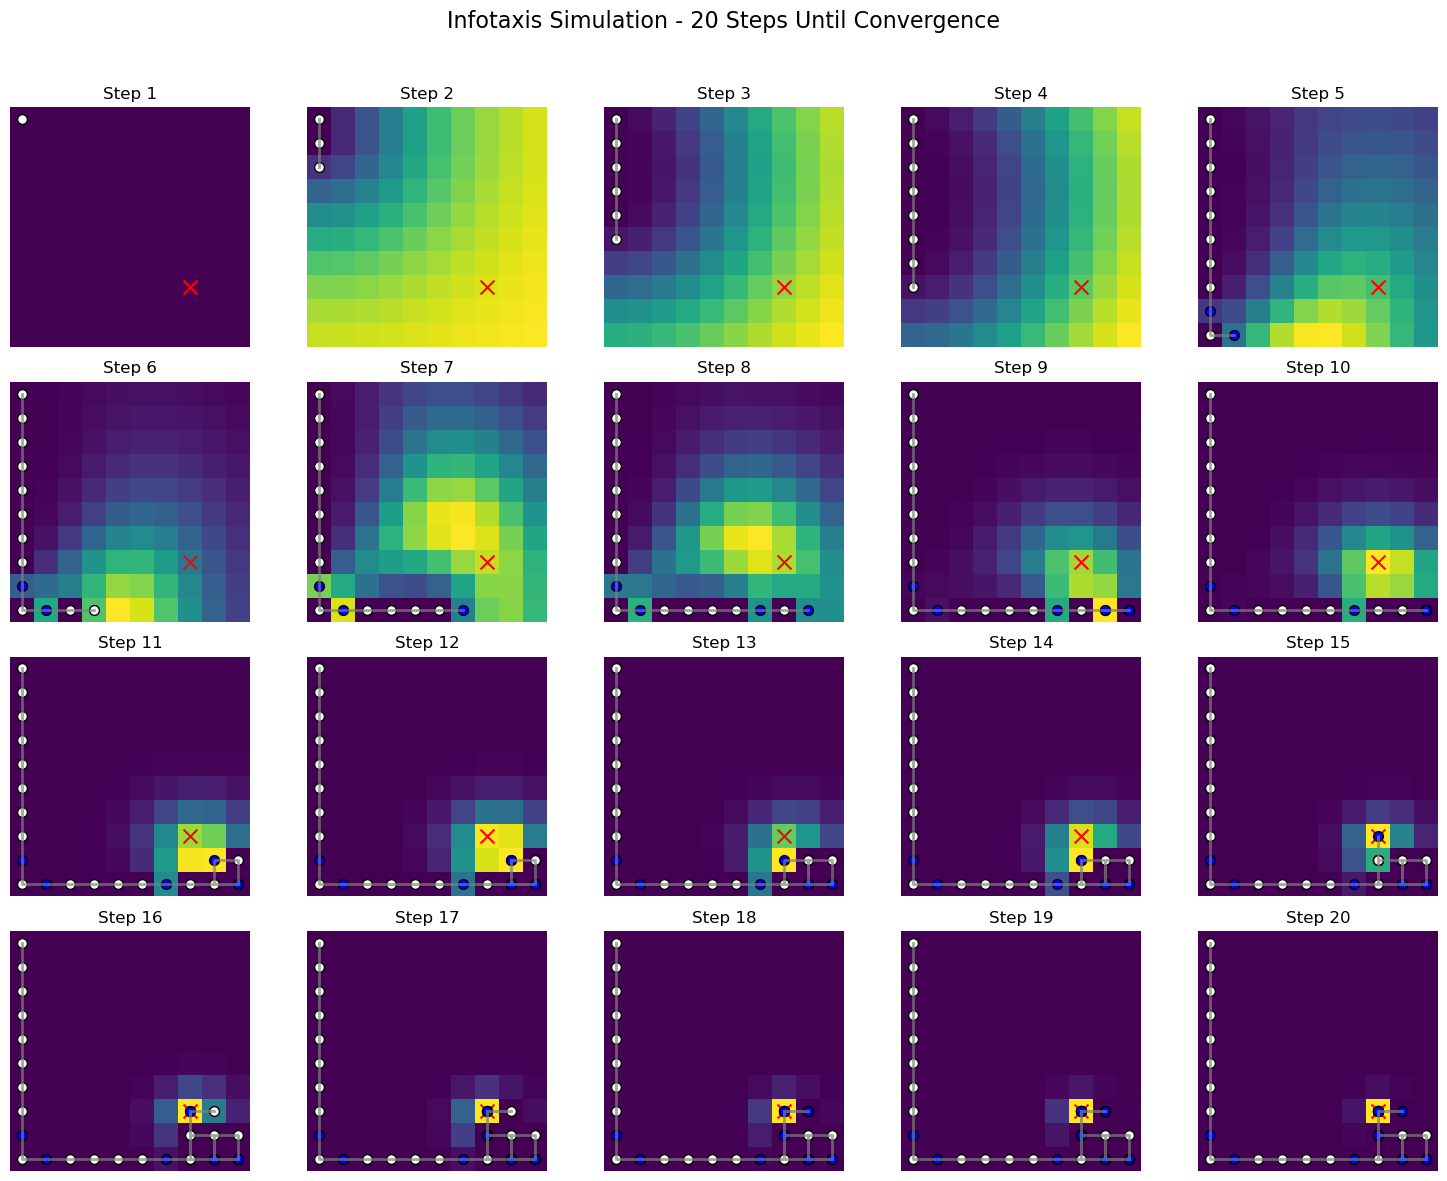

In [1]:
# Re-import necessary libraries since the execution state was reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up grid
grid_size = 10
source_location = (7, 7)  # Hidden gas leak source
searcher_position = (0, 0)  # Starting position

# Initialize belief distribution (uniform probability)
belief = np.ones((grid_size, grid_size)) / (grid_size * grid_size)

# Function to calculate gas detection probability (inverse squared distance decay)
def gas_probability(x, y, source_x, source_y):
    distance = np.sqrt((x - source_x) ** 2 + (y - source_y) ** 2)
    return np.exp(-distance / 3)  # Exponential decay for realism

# Function to update belief distribution using Bayes' rule
def update_belief(belief, searcher_pos, detected_signal):
    x_s, y_s = searcher_pos
    likelihood = np.zeros_like(belief)

    for i in range(grid_size):
        for j in range(grid_size):
            prob = gas_probability(i, j, x_s, y_s)
            likelihood[i, j] = prob if detected_signal else (1 - prob)

    # Apply Bayes' rule: P(source | data) ∝ P(data | source) * P(source)
    belief *= likelihood
    belief /= np.sum(belief)  # Normalize

    return belief

# Function to compute entropy of belief distribution
def compute_entropy(belief):
    return -np.sum(belief * np.log(belief + 1e-10))  # Add small value to avoid log(0)

# Function to select next move based on infotaxis
def select_next_move(belief, searcher_pos):
    x, y = searcher_pos
    possible_moves = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
    possible_moves = [(i, j) for i, j in possible_moves if 0 <= i < grid_size and 0 <= j < grid_size]

    best_move = None
    best_entropy_reduction = -np.inf

    for move in possible_moves:
        simulated_belief = update_belief(belief.copy(), move, True)  # Assume detection for estimation
        entropy_reduction = compute_entropy(belief) - compute_entropy(simulated_belief)
        if entropy_reduction > best_entropy_reduction:
            best_entropy_reduction = entropy_reduction
            best_move = move

    return best_move

# Define convergence criteria and run the infotaxis simulation until convergence

# Reset belief distribution and searcher position
belief = np.ones((grid_size, grid_size)) / (grid_size * grid_size)
searcher_position = (0, 0)

# Store searcher trajectory and detection status
searcher_trajectory = [searcher_position]
detection_status = []  # True if detected, False otherwise
belief_evolution = [belief.copy()]  # Store step 0

# Convergence criteria: belief concentrated at a single location
convergence_threshold = 0.9  # At least 90% probability mass at a single location
max_iterations = 100  # Prevent infinite loops
converged = False

for step in range(max_iterations):
    # Simulate gas detection
    x_s, y_s = searcher_position
    detection_prob = gas_probability(x_s, y_s, *source_location)
    detected_signal = np.random.rand() < detection_prob
    detection_status.append(detected_signal)

    # Update belief
    belief = update_belief(belief, searcher_position, detected_signal)

    # Store belief evolution for visualization
    belief_evolution.append(belief.copy())

    # Select next move based on infotaxis
    searcher_position = select_next_move(belief, searcher_position)
    searcher_trajectory.append(searcher_position)  # Track movement

    # Check convergence (at least 90% belief at a single location)
    if np.max(belief) >= convergence_threshold:
        converged = True
        break

# Select 20 evenly spaced steps from the full trajectory for visualization
num_steps_to_show = 20
selected_steps = np.linspace(0, step, num_steps_to_show, dtype=int)

# Set up the figure with a 4x5 grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))
fig.suptitle("Infotaxis Simulation - 20 Steps Until Convergence", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each selected step in its respective subplot
for idx, (step, ax) in enumerate(zip(selected_steps, axes)):
    sns.heatmap(belief_evolution[step], cmap="viridis", square=True, cbar=False, ax=ax)
    ax.scatter(source_location[1] + 0.5, source_location[0] + 0.5, color='red', marker='x', s=100, label="Source")

    # Plot searcher trajectory up to current step
    trajectory_x = [pos[1] + 0.5 for pos in searcher_trajectory[:step+1]]
    trajectory_y = [pos[0] + 0.5 for pos in searcher_trajectory[:step+1]]
    ax.plot(trajectory_x, trajectory_y, color='gray', linestyle='-', linewidth=2, alpha=0.7)

    # Plot searcher positions with detection/no detection markers
    for i in range(step + 1):
        x, y = searcher_trajectory[i][1] + 0.5, searcher_trajectory[i][0] + 0.5
        if i < len(detection_status):  # Avoid out-of-range errors
            if detection_status[i]:
                ax.scatter(x, y, color='blue', edgecolors='black', marker='o', s=50)
            else:
                ax.scatter(x, y, color='white', edgecolors='black', marker='o', s=50)

    ax.set_title(f"Step {idx + 1}")
    ax.axis("off")

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Above shows 20 equally spaced steps wihtin the 63 steps it took to converge, but anotehr convergence criteria could be when the entropy(or the information uncertainty threshold) is below a certain level, indicating that it's close to the target. Although suboptimal, infotaxis always does converge to its source.  